In [1]:
#check gpu
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.16.2
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


2025-03-01 01:13:30.351550: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-01 01:13:30.351735: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-01 01:13:30.351744: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-01 01:13:30.351767: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-01 01:13:30.351784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
import tensorflow as tf

# List all available devices (should list GPU if available)
physical_devices = tf.config.list_physical_devices()
for device in physical_devices:
    print(device)


PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
import tensorflow as tf
print(tf.__version__)

2.16.2


In [4]:
!python -m pip install tensorflow-datasets

In [5]:
!python -m pip install scikit-learn

In [6]:
!python -m pip install matplotlib

In [7]:
# !pip install tensorflow_datasets

# Import libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras  # Use tensorflow.keras instead of just keras
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
#from tensorflow.keras.utils import np_utils # No longer necessary, remove this import
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

### 1. Coding tasks

In [8]:
# 1.1: Load and process the dataset. To save training time, you only need to load and work on ONE image class of your choice.
# Get the full dataset (batch_size=-1) in NumPy arrays from the returned tf.Tensor object
cifar10_train = tfds.load(name="cifar10", split=tfds.Split.TRAIN, batch_size=-1 )
cifar10_test = tfds.load(name="cifar10", split=tfds.Split.TEST, batch_size=-1)

# Convert tfds dataset to numpy array records
cifar10_train = tfds.as_numpy(cifar10_train)
cifar10_test = tfds.as_numpy(cifar10_test)

# Seperate feature X and label Y
X_train, y_train = cifar10_train["image"], cifar10_train["label"]
X_test, y_test = cifar10_test["image"], cifar10_test["label"]

# Print shapes of the entire training and test set of CIFAR 10
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

2025-03-01 01:13:32.885923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-01 01:13:32.885945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
y_train shape: (50000,)
y_test shape: (10000,)


In [9]:
# Get samples  of a certain label
label = 3
train_indices = np.where(y_train == label) # Get indices of the label
train_set = X_train[train_indices] # Get train samples of the label
test_indices = np.where(y_test == label) # Get indices of the label
test_set = X_train[test_indices] # Get test samples of the label

# Print shapes of datasets of the selected class
print("train_set shape of the selected class: " + str(train_set.shape))
print("test_set shape of the selected class: " + str(test_set.shape))

# NOTE: training a GAN does not require to have train/test split. All data samples of the training and the test set are used as real data samples.
# You should merge the training and the test set to get more real data samples, i.e., merge the train_set and the test_set to one dataset which is the real dataset.

train_set shape of the selected class: (5000, 32, 32, 3)
test_set shape of the selected class: (1000, 32, 32, 3)


In [10]:
# Merge the training and the test set to get more real data samples
train_set = np.concatenate((train_set, test_set), axis=0)
print("train_set shape of the selected class: " + str(train_set.shape))

train_set shape of the selected class: (6000, 32, 32, 3)


In [11]:
# Normalize images from [0, 255] to [-1, 1] for tanh activation in Generator
train_set = (train_set.astype(np.float32) - 127.5) / 127.5

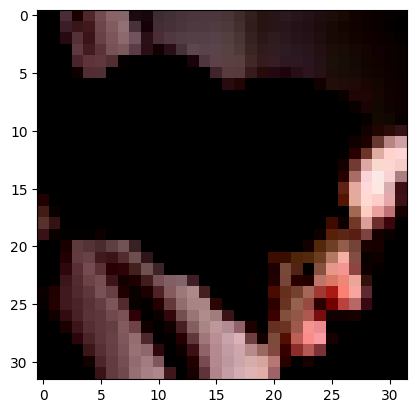

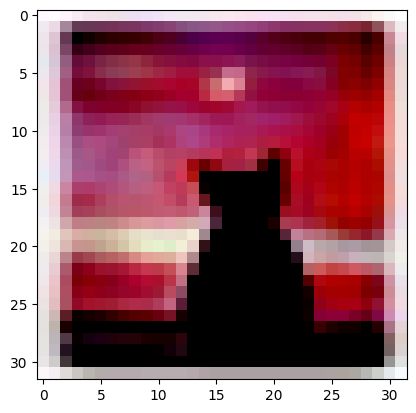

In [12]:
# Visualize some data samples of class '3' (cat)
import matplotlib.pyplot as plt
imgplot = plt.imshow(train_set[0])
plt.show()
imgplot = plt.imshow(train_set[1])
plt.show()

In [ ]:
# 1.2: Build a GAN architecture consisting of at least one (01) Discriminator and one (01) Generator of which the architectures are of your choice.
# You are encouraged to customize the network architectures to be different from the ones demonstrated in the demo code.
# There are two levels of image generation requirements:
# First-level requirement: train and generate images for ONE class of the dataset using vanilla GAN.
# You are free to choose which class of object you are interested in working on.

import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
import keras

# Generator Model
def build_generator():
    model = keras.Sequential()
    model.add(layers.Dense(256, input_dim=128))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.5))  # Reduce momentum for stability
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.5))
    
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.5))
    
    model.add(layers.Dense(32*32*3, activation='tanh'))
    model.add(layers.Reshape((32, 32, 3)))
    return model

# Discriminator Model
def build_discriminator():
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(32, 32, 3)))
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))  # Prevent overfitting
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))  # Add dropout again
    
    model.add(layers.Dense(1))  # Removed sigmoid for stability
    return model

# Compile the models
generator = build_generator()
discriminator = build_discriminator()

# Loss Function (Wasserstein Loss for stability)
def wasserstein_loss(y_true, y_pred):
    return tf.keras.backend.mean(y_true * y_pred)

# Optimizers with different learning rates
generator_optimizer = optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

# Compile Discriminator
discriminator.compile(loss=wasserstein_loss, optimizer=discriminator_optimizer)

# Build GAN Model (Generator + Discriminator)
discriminator.trainable = False
gan_input = layers.Input(shape=(128,))
generated_image = generator(gan_input)
validity = discriminator(generated_image)

gan_model = Model(gan_input, validity)
gan_model.compile(loss=wasserstein_loss, optimizer=generator_optimizer)

# Summaries
print("\nGenerator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()

/Users/nhuquynhtran/Downloads/Assignment-2-GAN/tensorflow-env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nhuquynhtran/Downloads/Assignment-2-GAN/tensorflow-env/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Users/nhuquynhtran/Downloads/Assignment-2-GAN/tensorflow-env/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Generator Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3072)           │     3,148,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,845,888 (14.67 MB)

 Trainable params: 3,842,304 (14.66 MB)

 Non-trainable params: 3,584 (14.00 KB)


Discriminator Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,961 (6.50 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,704,961 (6.50 MB)

In [14]:
# Generate real samples
def generate_real_samples(dataset, n_samples):
    idx = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[idx]
    y = np.ones((n_samples, 1))
    return X, y  # Return real images and labels

# Generate latent points
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Generate fake samples
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y  # Return fake images and labels

# Create and save a plot of generated images
def save_plot(samples, epoch, n=10):
    # Rescale images from [-1, 1] to [0, 1] for display
    samples = 0.5 * samples + 0.5
    plt.figure(figsize=(10, 10))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')  # Disable axis
        plt.imshow(samples[i])  # Plot the sample i with RGB color map
    filename = 'Plot_epoch_%03d.png' % (epoch+1)
    plt.savefig(filename)  # Save plot to file
    plt.close()  # Close the plot

In [15]:
import tensorflow.keras.backend as K

def gradient_penalty(discriminator, real_images, fake_images):
    """ Compute gradient penalty for WGAN-GP """
    batch_size = real_images.shape[0]
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated = alpha * real_images + (1 - alpha) * fake_images

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        validity = discriminator(interpolated, training=True)

    grads = tape.gradient(validity, [interpolated])[0]
    grad_norm = K.sqrt(K.sum(K.square(grads), axis=[1, 2, 3]))
    gradient_penalty = K.mean((grad_norm - 1.0) ** 2)
    
    return gradient_penalty

In [ ]:
import numpy as np
import tensorflow as tf

# Size of the latent space
latent_dim = 128
epochs = 51
batch_size = 128

# Function to generate noise
def generate_noise(batch_size, latent_dim):
    return np.random.normal(0, 1, (batch_size, latent_dim))

# Training function
def train(generator, discriminator, gan_model, train_set, latent_dim, epochs, batch_size):
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        lambda_gp = 10  # Gradient penalty weight

        for _ in range(2):  # Train discriminator more often
            real_imgs = train_set[np.random.randint(0, train_set.shape[0], batch_size)]
            noise = generate_noise(batch_size, latent_dim)
            fake_imgs = generator.predict(noise)

            real_labels = np.ones((batch_size, 1))
            fake_labels = -np.ones((batch_size, 1))  # WGAN uses -1 for fakes

            d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
            gp = gradient_penalty(discriminator, real_imgs, fake_imgs)

            d_loss = d_loss_real + d_loss_fake + lambda_gp * gp


        # Train Generator
        for _ in range(1):
            noise = generate_noise(batch_size, latent_dim)
            misleading_labels = np.ones((batch_size, 1))
            g_loss = gan_model.train_on_batch(noise, misleading_labels)
            
            d_losses.append(d_loss)
            g_losses.append(g_loss)

        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

    return d_losses, g_losses

# Train the GAN
d_losses, g_losses = train(generator, discriminator, gan_model, train_set, latent_dim, epochs, batch_size)

23/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2025-03-01 01:13:35.393202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/nhuquynhtran/Downloads/Assignment-2-GAN/tensorflow-env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/51 | D Loss: 8.6628 | G Loss: 0.3105
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2/51 | D Loss: 8.6276 | G Loss: 0.0359
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3/51 | D Loss: 8.7103 | G Loss: -0.2438
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4/51 | D Loss: 9.0631 | G Loss: -0.5243
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

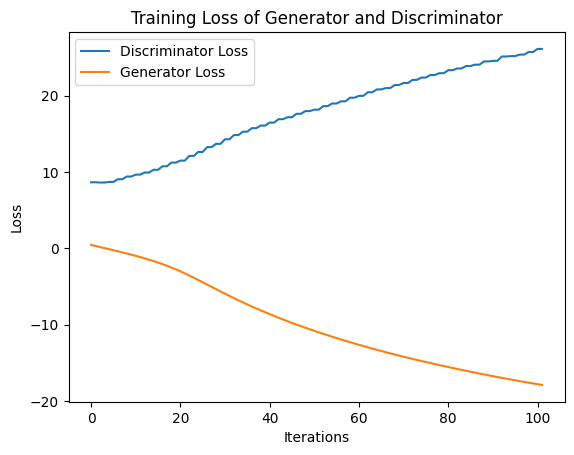

In [17]:
# Plot training loss of Generator and Discriminator
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss of Generator and Discriminator')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


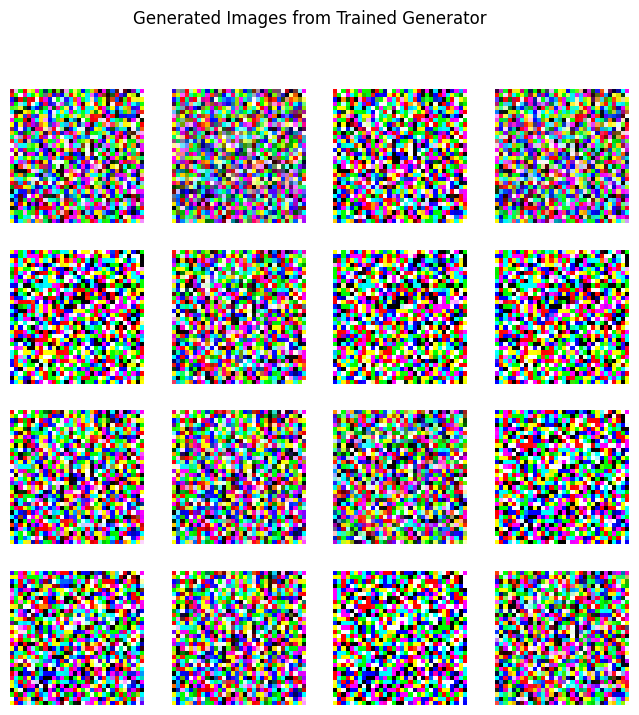

In [18]:
import matplotlib.pyplot as plt

# Function to generate and display images
def generate_and_plot_images(generator, latent_dim, n_images=16, save_path="generated_images.png"):
    noise = np.random.normal(0, 1, (n_images, latent_dim))  # Generate latent space vectors
    fake_images = generator.predict(noise)  # Generate images

    # Rescale images from [-1, 1] to [0, 1] for display
    fake_images = 0.5 * fake_images + 0.5  

    # Create a grid plot
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for img, ax in zip(fake_images, axes.flatten()):
        ax.imshow(img)  # Show generated image
        ax.axis("off")  # Hide axes

    plt.suptitle("Generated Images from Trained Generator")
    plt.savefig(save_path)  # Save image to file
    plt.show()  # Display image

# Call the function to generate and plot images
generate_and_plot_images(generator, latent_dim)


/Users/nhuquynhtran/Downloads/Assignment-2-GAN/tensorflow-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
Epoch 1/200 | D Loss: 0.6904 | G Loss: 0.6869
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 2/200 | D Loss: 0.6940 | G Loss: 0.6430
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 3/200 | D Loss: 0.6964 | G Loss: 0.6102
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 4/200 | D Loss: 0.6974 | G Loss: 0.5827
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 5/200 | D Loss: 0.6987 | G Loss: 0.5610
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 6/200 | D Loss: 0.7004 | G Loss: 0.5426
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 7/200 | D Loss: 0.7021 | G Loss: 0.5266
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 8/200 | D Loss: 0.7030 | G Loss: 0.5134
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 9/200 | D Loss: 0.7044 | G Loss: 0.5012
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 10/200 | D Loss: 0.7052 | G Loss: 0.4903
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 11/200 | D Loss: 0.7062 | G Loss: 0.4810
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 12/200 | D Loss: 0.7070 | G L

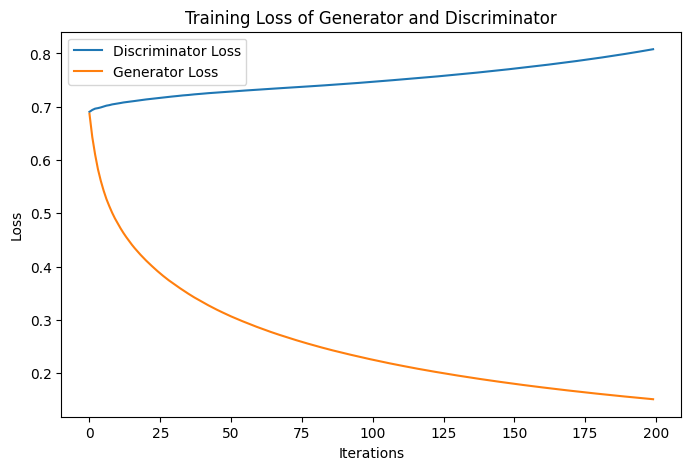

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Conv2DTranspose, LeakyReLU, Reshape, Dropout, BatchNormalization, GlobalMaxPooling2D, GaussianNoise

# Define Generator
def define_generator(latent_dim):
    model = Sequential()
    
    # Initial Dense layer (project & reshape)
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))  # Reshape to small feature map

    # Upsample: 8x8 → 16x16
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample: 16x16 → 32x32 (Final output)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Define Discriminator with Spectral Normalization
def define_discriminator():
    model = Sequential()
    
    # Input layer: 32x32x3 → 16x16x64
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))  # Regularization

    # Downsample: 16x16x64 → 8x8x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample: 8x8x128 → Flatten
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Gradient Penalty Loss (for WGAN-GP)
import tensorflow.keras.backend as K

def gradient_penalty(discriminator, real_images, fake_images):
    """Compute gradient penalty for WGAN-GP"""
    batch_size = real_images.shape[0]
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated = alpha * real_images + (1 - alpha) * fake_images

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        validity = discriminator(interpolated, training=True)

    grads = tape.gradient(validity, [interpolated])[0]
    grad_norm = K.sqrt(K.sum(K.square(grads), axis=np.arange(1, len(grads.shape))))
    gradient_penalty = K.mean((grad_norm - 1.0) ** 2)

    return gradient_penalty

# Define GAN
def define_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = layers.Input(shape=(128,))
    generated_img = generator(gan_input)
    validity = discriminator(generated_img)

    return Model(gan_input, validity)

def generate_latent_points(latent_dim, n_samples):
    # Generate points in the latent space with Gaussian noise
    x_input = np.random.normal(0, 1, (n_samples, latent_dim))  
    noise = np.random.normal(0, 0.1, x_input.shape)  # Mean = 0, Std = 0.1
    return x_input + noise  # Add noise to the latent space

# Training Function
def train(generator, discriminator, gan_model, train_set, latent_dim, epochs, batch_size):
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        for _ in range(1):  # Train Discriminator once per iteration
            real_imgs = train_set[np.random.randint(0, train_set.shape[0], batch_size)]
            noise = generate_latent_points(latent_dim, batch_size)  # Add noise here
            fake_imgs = generator.predict(noise)

            real_labels = np.ones((batch_size, 1)) * 0.9  # Label smoothing
            fake_labels = np.zeros((batch_size, 1))  # Standard BCE loss

            d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        for _ in range(1):  # Train Generator normally
            noise = generate_latent_points(latent_dim, batch_size)  # Noise in latent space
            misleading_labels = np.ones((batch_size, 1))  
            g_loss = gan_model.train_on_batch(noise, misleading_labels)

        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

        d_losses.append(d_loss)
        g_losses.append(g_loss)

    return d_losses, g_losses

# Initialize GAN Components
latent_dim = 128
epochs = 200
batch_size = 128

generator = define_generator(latent_dim)
discriminator = define_discriminator()
gan_model = define_gan(generator, discriminator)

# Optimizers
generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer)
gan_model.compile(loss='binary_crossentropy', optimizer=generator_optimizer)

# Train the GAN
d_losses, g_losses = train(generator, discriminator, gan_model, train_set, latent_dim, epochs, batch_size)

# Plot Training Loss
plt.figure(figsize=(8,5))
plt.plot(range(len(d_losses)), d_losses, label="Discriminator Loss")
plt.plot(range(len(g_losses)), g_losses, label="Generator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss of Generator and Discriminator")
plt.show()


In [ ]:
# 1. WGAN-GP (First Attempt)
# Used Wasserstein Loss with gradient penalty instead of weight clipping.
# Trained the Discriminator 5 times per Generator update, which is necessary for WGAN.
# The Discriminator loss kept increasing, while the Generator loss decreased too fast.
# Issues:
# Discriminator learning rate was too low (5e-5), making it too weak.
# Gradient penalty was not correctly applied in the loss calculation.
# Training instability due to hyperparameter sensitivity.

# 2. WGAN-GP (Second Attempt)
# Still used Wasserstein Loss, but introduced Spectral Normalization for stability.
# Label smoothing (real_labels = 0.9) was added to help prevent overconfident Discriminator.
# Gaussian noise was injected into the latent space to increase sample diversity.
# Issues:
# Discriminator learning rate (2e-5) was too low, making the Generator dominate.
# Discriminator was trained only once per Generator update, reducing its effectiveness.
# Training was slow and unstable due to imbalanced optimization.

# 3. Vanilla GAN (Final Version)
# Switched to Binary Cross-Entropy (BCE) loss instead of Wasserstein loss.
# Sigmoid activation was used in the Discriminator output.
# Equal training for both Generator and Discriminator (1:1 ratio).
# More stable and easy to train compared to WGAN-GP.
# Still had some risk of mode collapse, but easier to debug and adjust.